In [1]:
#Save the below parameters to output.txt file
%logstart -o -r -t -q output.txt rotate

In [2]:
# General info
# using Adam Optimization
# Shuffling sources every epoch
# SCHUSTER's MARMOUSI MODEL

# General parameters
GPU=5     # which GPU to use
plot=False # Plot Intermediate results
sigma=7.5   # Initial model smoothness  

# Inversion parameters
num_batches = 4
num_epochs = 5000

#gamma = 300  # Does not apply, Adam uses lr (learning rate) instead of gamma
# Adam learning rate
lr = 4

# Modeling parameters
freq = 14
dx = 10
dt = 0.001
nt = 4001
num_shots = 16
num_receivers_per_shot = 100

# receiver_spacing = # computed below from ny,dx and num_receivers_per_shot

# Close the ouput.txt file with saved parameters
%logstop 

In [3]:
# Need to restart runtime before this step
import time
import torch
import numpy as np
import scipy.ndimage
import scipy.io
import matplotlib.pyplot as plt
import deepwave
import os
import csv
from sklearn.feature_extraction import image
from skimage.transform import resize

In [4]:
NX = 800;
NY = 186;
DH = 25.0;
f = open("AllModels/overthrust_true.vp")
data_type = np.dtype ('float32').newbyteorder ('<')
overthrust = np.fromfile (f, dtype=data_type)
overthrust = overthrust.reshape(NX,NY)
overthrust = np.transpose(overthrust)
overthrust = overthrust[0:130,0:550]
overthrust = resize(overthrust, (151, 201))
mat = overthrust

In [5]:
plot=True
ny = np.size(mat,1);
nz = np.size(mat,0);
#RB compute true model mean value and width for future model normalization
max1=np.max(mat)
min1=np.min(mat)
med=(max1+min1)/2.
wid=(max1-min1)/2.

print('vmin=',min1,'vmax=',max1,'vmed=',med,'vwidth=',wid)

vmin= 2414.9575 vmax= 5500.0 vmed= 3957.478759765625 vwidth= 1542.521240234375


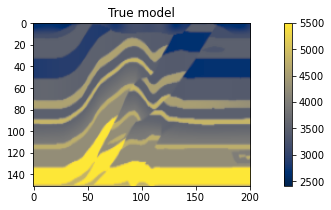

In [6]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(mat,vmin=min1,vmax=max1, aspect=1,cmap='cividis')
    plt.title('True model')
    plt.colorbar()

In [7]:
#RB Open file to write results
f = open('marmsm_Mod8_log.txt','a+')
writer = csv.writer(f)

#RB Write header
fields=['Epoch','it','loss.item','epoch_loss','it_lap','epoch_lap']
writer.writerow(fields)
f.flush()
os.fsync(f)

In [8]:
# Specify which GPU to use (in multi GPU machines)
torch.cuda.set_device(GPU)  #RB Necessary if device <> 0
GPU_string='cuda:'+str(GPU)
device = torch.device(GPU_string)

In [9]:
# Set parameters
num_dims = 2
#num_shots = 32
num_sources_per_shot = 1
#num_receivers_per_shot = 200

#RB source_spacing = 25.0
#RB receiver_spacing = 10.0
source_spacing = ny * dx / num_shots
receiver_spacing = ny * dx / num_receivers_per_shot
#receiver_spacing = 8.

print('ny=',ny,'nz=',nz,'nt=',nt,'dx=',dx,'freq=',freq)
print('shots=',num_shots,'recs/shot=',num_receivers_per_shot, \
      'ds=',source_spacing,'dr=',receiver_spacing)


ny= 201 nz= 151 nt= 4001 dx= 10 freq= 14
shots= 16 recs/shot= 100 ds= 125.625 dr= 20.1


In [10]:
# Create arrays containing the source and receiver locations
# x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions]
# x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]
x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
x_s[:, 0, 1] = torch.arange(num_shots).float() * source_spacing
#x_s[:, 0, 0] = 100. #RB Set source depth

x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
x_r[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
x_r[:, :, 1] = x_r[0, :, 1].repeat(num_shots, 1)

#RB Shuffle shot coordinates
###idx = torch.randperm(num_shots)
###x_s = x_s.view(-1,2)[idx].view(x_s.size())

#RB Set Receiver depth
#x_r[0, :, 0] = 100.
#x_r[:, :, 0] = x_r[0, :, 0].repeat(num_shots, 1)

# Create true source amplitudes [nt, num_shots, num_sources_per_shot]
# I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you
# can use whatever Tensor you want as the source amplitude.
source_amplitudes_true = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                          .reshape(-1, 1, 1)
                          .repeat(1, num_shots, num_sources_per_shot))

In [11]:
#RB Generate a cte velocy model (with water velocity)
mat2 = np.ones((nz,ny),np.float32)*1500.

mat2[nz-1,int(ny/2)]=max1  # put a pixel with true upper velocity to fix a propagator problem

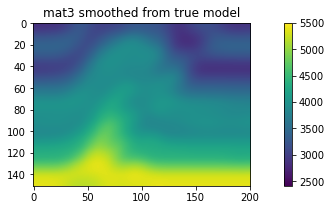

In [12]:
#RB Create a smoothed model

#RB start with true model
mat3 = np.copy(mat)
#RB Filter image heavly
mat3 = scipy.ndimage.gaussian_filter(mat3,sigma=sigma) #10,50  #5%,10%
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(mat3,vmin=min1,vmax=max1)
    plt.title('mat3 smoothed from true model')
    plt.colorbar()
    
#mat3 = 2200*np.ones(np.shape(mat))
#RB Force water table to be 1500 m/s (avoid imperfect direct wav removal)    
#mat3[0:26,:]=1500.

#RB Plot model
#if plot==True:
#    plt.figure(figsize=(12, 3))
#    plt.imshow(mat3,vmin=min1,vmax=max1)
#    plt.title('mat3 fixed water table')
#    plt.colorbar()

#RB We may want to smooth the water table transition
#RB but I think it's a bad idea (not tested)
# mat3 = scipy.ndimage.gaussian_filter(mat3,sigma=4)

#RB Optionally we may import a initial model from file
#filename='Marm151_401_smooth.mat'
#mat3=scipy.io.loadmat(filename)['vel0']

#RB Ensure that the initial model has the same range of the true model by
#RB forcing one of its slowest pixel to have the true's model lower velocity and
#RB forcing one of its fastest pixel to have the true's model upper velocity
#RB find max & min values of mat3
smin=np.min(mat3)
smax=np.max(mat3)
indmin = np.where(mat3==smin)
indmax = np.where(mat3==smax)
# Take first pixel with minimum velocity and force it to true's model minimum velocity
mat3[indmin[0][0],indmin[1][0]]=min1
# Take first pixel with maximum velocity and force it to true's model maximum velocity
mat3[indmax[0][0],indmax[1][0]]=max1

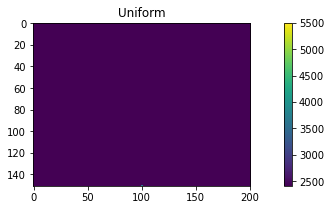

In [13]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(mat2,vmin=min1,vmax=max1, aspect=1)
    plt.title('Uniform')
    plt.colorbar()

In [14]:
#RB Convert models to PyTorch Tensors
model_true = torch.Tensor(mat) # Convert to a PyTorch Tensor
model_cte = torch.Tensor(mat2) # Convert to a PyTorch Tensor

In [15]:
###### Create 'true' data 
prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx)
receiver_amplitudes_all = prop(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()
seis=np.squeeze(receiver_amplitudes_all.cpu().detach().numpy())
#seis = seis.swapaxes(1,2)
#seis = seis.swapaxes(0,1)
#receiver_amplitudes_all = receiver_amplitudes_all.swapaxes(1,2)

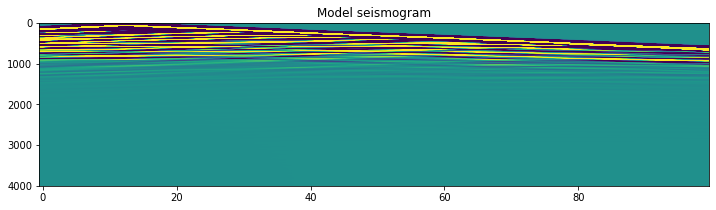

In [16]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(receiver_amplitudes_all[:,2].cpu().detach().numpy(),vmin=-.05,vmax=.05, aspect='auto')
    plt.title('Model seismogram')

In [17]:
# Exclude direct waves from true data (they don't bring info from subsurface)
receiver_amplitudes_true = receiver_amplitudes_all

In [19]:
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/')

          
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/trainA')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/trainB')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/trainC')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/trainD')

os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/testA')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/testB')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/testC')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/testD')

os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/trainA')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/trainB')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/trainC')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/trainD')

os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/testA')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/testB')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/testC')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/testD')

0

In [20]:

A = mat
B = mat3
C = seis

for kk in range(1,2):
    
    #kk = 1
    D = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi/ZZConstant0ep'+str(kk)+'.npy')
            
    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/trainA/'+str(kk)+'.npy','wb')
    np.save(file,A)
    file.close()

    
    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/trainB/'+str(kk)+'.npy','wb')
    np.save(file,B)
    file.close()


    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/trainC/'+str(kk)+'.npy','wb')
    np.save(file,C)
    file.close()

    
    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/trainD/'+str(kk)+'.npy','wb')
    np.save(file,D)
    file.close()

In [22]:
for kk in range(1,2):
    
    #kk = 1
    D = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi/ZZConstant0ep'+str(kk)+'.npy')
            
    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/testA/'+str(kk)+'.npy','wb')
    np.save(file,A)
    file.close()
    

    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/testB/'+str(kk)+'.npy','wb')
    np.save(file,B)
    file.close()


    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/testC/'+str(kk)+'.npy','wb')
    np.save(file,C)
    file.close()
    

    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Overthrust/testD/'+str(kk)+'.npy','wb')
    np.save(file,D)
    file.close()

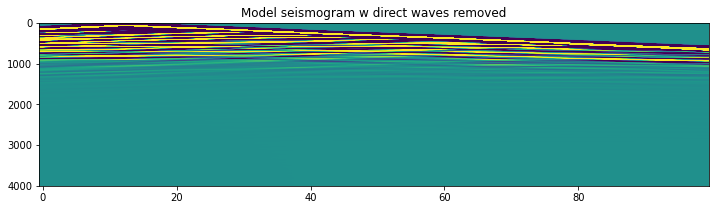

In [68]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(receiver_amplitudes_true[:,2].cpu().detach().numpy(),vmin=-.05,vmax=.05, aspect='auto')
    plt.title('Model seismogram w direct waves removed')

In [69]:
#RB Normalize initial model to (-1,1) range
#model_init = (mat3-med)/wid
#RB_No_normalization
model_init = mat3

In [70]:
# Convert to Pytorch tensor
#model_init = torch.from_numpy(np.float32(model_init))
model_init = torch.Tensor(model_init)

# Make a copy so at the end we can see how far we came from the initial model
model = model_init.clone()
model = model.to(device)
model.requires_grad = True

In [71]:
#RB AS I am not inverting for source, I could just do
#RB source_amplitudes = source_amplitudes_true.clone().to(device)
#RB instead of all code below

# Create initial guess source amplitude for inversion
# I will assume that the true source amplitude is the same for every shot
# so I will just create one source amplitude, and PyTorch will backpropagate
# updates to it from every shot
source_amplitudes_init = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                          .reshape(-1, 1, 1))
source_amplitudes = source_amplitudes_init.clone()
source_amplitudes = source_amplitudes.to(device)
#source_amplitudes.requires_grad_(); # Alternative way of requiring gradient

In [72]:
# To demonstrate chaining operations, during the inversion I will normalise the
# predicted receiver amplitudes so that each trace has a maximum value of 1.
# This will be compared (in the cost function) with the true data that has been
# similarly scaled. I apply that scaling to the true data now.
# This sort of scaling might be useful for real data where the absolute
# amplitudes are often not meaningful.
rcv_amps_true_max, _ = receiver_amplitudes_true.max(dim=0, keepdim=True)
rcv_amps_true_norm = receiver_amplitudes_true / rcv_amps_true_max

In [73]:
# Set-up inversion
#gamma = 300
criterion = torch.nn.MSELoss()
#RB optimizer = torch.optim.SGD([{'params': model }],lr = 100000., momentum=0)
optimizer = torch.optim.Adam([{'params': [model], 'lr': lr}])

Processing Epoch: 0
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 0 Loss:  0.020094629377126694


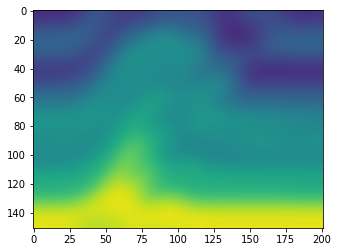

Processing Epoch: 1
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 1 Loss:  0.01832658238708973
Processing Epoch: 2
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 2 Loss:  0.016488796565681696
Processing Epoch: 3
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 3 Loss:  0.014845825266093016
Processing Epoch: 4
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 4 Loss:  0.013156838715076447
Processing Epoch: 5
shape of predicte

Epoch: 34 Loss:  0.0023225366603583097
Processing Epoch: 35
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 35 Loss:  0.0022679047542624176
Processing Epoch: 36
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 36 Loss:  0.0022145350521896034
Processing Epoch: 37
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 37 Loss:  0.002163902739994228
Processing Epoch: 38
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 38 Loss:  0.002114

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 68 Loss:  0.0012922725290991366
Processing Epoch: 69
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 69 Loss:  0.0012742379331029952
Processing Epoch: 70
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 70 Loss:  0.0012583294010255486
Processing Epoch: 71
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 71 Loss:  0.0012428527406882495
Processing Epoch: 72
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch

shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 102 Loss:  0.0009676179324742407
Processing Epoch: 103
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 103 Loss:  0.0009624647645978257
Processing Epoch: 104
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 104 Loss:  0.0009564736974425614
Processing Epoch: 105
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 105 Loss:  0.0009506320348009467
Processing Epoch: 106
shape of predicted
torch.Size([4001, 4, 100])
shape of predict

shape of predicted
torch.Size([4001, 4, 100])
Epoch: 135 Loss:  0.0008229827071772888
Processing Epoch: 136
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 136 Loss:  0.0008194530819309875
Processing Epoch: 137
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 137 Loss:  0.0008162778249243274
Processing Epoch: 138
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
Epoch: 138 Loss:  0.0008130542264552787
Processing Epoch: 139
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predicted
torch.Size([4001, 4, 100])
shape of predict

In [ ]:
#%%capture cap --no-stderr 
# The line above captures the output of this cell to the variable cap

# Iterative inversion loop
t_start = time.time()

##num_batches = 32 # split data into batches for speed and reduced memory use
num_shots_per_batch = int(num_shots / num_batches)
##num_epochs = 1000 # Pass through the entire dataset 30 times

#vmin, vmax = np.percentile(model_true.numpy(), [2,98]) # For plotting
vmin = min1
vmax = max1
#vmin=-1
#vmax= 1
# Temperature coefficient
##Tk =50



for epoch in range(num_epochs):
    ep_start=time.time()
    print('Processing Epoch:',epoch)
    epoch_loss = 0.0
    
    #RB Shuffle shot coordinates
    idx = torch.randperm(num_shots)
    x_s = x_s.view(-1,2)[idx].view(x_s.size())
    #RB Shuffle true's seismograms sources with same random values
    rcv_amps_true_norm = rcv_amps_true_norm[:,idx,:]
    #RB Shuffle direct wave seismograms sources with the same random values
    #receiver_amplitudes_cte = receiver_amplitudes_cte[:,idx,:]
    #print(np.shape(rcv_amps_true_norm))
    
    for it in range(num_batches):
        it_start = time.time()
        ###print('    Processing Batch:',it,' of', num_batches)
        
        optimizer.zero_grad()
        #if model.grad is not None:
        #    model.grad.data.zero_()
        #    print('Preexinting Model Grad zeroed')
            
        #RB Denormalize model to perform forward propagation
        #model2=model*wid+med
        #RB or no denormalization if using Adam
        model2=model.clone()
        #RB Clamp the model within acceptable range
        model2=torch.clamp(model,min=min1,max=max1)        
        
        #RB Make sure the model have same range of velocities of true's model (fix propag issue)
        #RB forcing one of its slowest pixel to have the true's model lower velocity and
        #RB forcing one of its fastest pixel to have the true's model upper velocity       
        #RB find max & min values of model2
        #smin=torch.min(model2)
        #smax=torch.max(model2)
        #indmin = torch.where(model2==smin)
        #indmax = torch.where(model2==smax)
        # Take first pixel with minimum velocity and force it to true's model minimum velocity
        #model2[indmin[0][0],indmin[1][0]]=min1
        # Take first pixel with maximum velocity and force it to true's model maximum velocity
        #model2[indmax[0][0],indmax[1][0]]=max1
        
        prop3 = deepwave.scalar.Propagator({'vp': model2}, dx)
        batch_src_amps = source_amplitudes.repeat(1, num_shots_per_batch, 1)
        batch_rcv_amps_true = rcv_amps_true_norm[:,it::num_batches].to(device)
        
        #RB Alternative normalization (normalizing to dTrue amplitude range)
        #batch_rcv_amps_true_max, _ = batch_rcv_amps_true.max(dim=0, keepdim=True)
        
        #RB get the seismogram of the direct wave for current batch
        #############batch_rcv_amps_cte = receiver_amplitudes_cte[:,it::num_batches].to(device)
        
        #RB get the current batch source & receiver coordinates
        batch_x_s = x_s[it::num_batches].to(device)
        batch_x_r = x_r[it::num_batches].to(device)

        #print('FWD Propag')
        #timer_a = time.time()
        
        batch_rcv_amps_pred = prop3(batch_src_amps, batch_x_s, batch_x_r, dt)
        
        #RB Subtract direct wave on all seismograms of current batch
        batch_rcv_amps_pred = batch_rcv_amps_pred
        
        #RB Normalize
        batch_rcv_amps_pred_max, _ = batch_rcv_amps_pred.max(dim=0, keepdim=True)
        batch_rcv_amps_pred_norm = batch_rcv_amps_pred / batch_rcv_amps_pred_max
        
        print("shape of predicted")
        print(np.shape(batch_rcv_amps_pred_norm))

        loss = criterion(batch_rcv_amps_pred_norm, batch_rcv_amps_true)            
        epoch_loss += loss.item()
        
        #timer_a = time.time()
        #print('Lap=',timer_a-timer_b)
        
        
        #print('Backpropagation')
    
        loss.backward()
        #model.grad[0:26,:]=0.
        
        
        #timer_b = time.time()
        #print('Lap=',timer_b-timer_a)
        
        #RB Hill climbing factor computation
        #low = 1-2*np.exp(-epoch/Tk)
        #alpha = np.random.uniform(low=low,high=1)
        #alpha = 1.
        
        #print('Model update')
        #with torch.no_grad():                
            #RB update model
        #    model =  model - torch.tanh(alpha*gamma*model.grad)                
        #model.requires_grad = True        
        optimizer.step()
        
        
        # Clamp model to acceptable range
        #with torch.no_grad():
        #    model=torch.clamp(model,min=min,max=max)
        #model.requires_grad = True
        
        it_end = time.time()
        #print('Lap=',it_end-timer_b)
        
        
    #RB Write variables to file at each epoch
    fields=[epoch,it,loss.item(),epoch_loss, it_end - it_start,it_end - ep_start]
    writer.writerow(fields)
    f.flush()
    os.fsync(f)
    
    print('Epoch:', epoch, 'Loss: ', epoch_loss)
    img = np.array(model.cpu().detach().numpy())

       
    if epoch % 200 == 0:
        
        if plot==True:
            plt.figure(figsize=(8, 4))
            plt.imshow(model.cpu().detach().numpy(), vmin=vmin, vmax=vmax,cmap='viridis')
            plt.show() 
            
        filename='Marmsm_Mod8_epoch_'+str(epoch)+'.mat'
        scipy.io.savemat(filename, mdict={'Model': img})
    
    epoch+=1

t_end = time.time()
print('Runtime:', t_end - t_start)

In [ ]:
plt.imshow(img)